# Codec

We're going to see if FSQ is a good fit for finding the tokens we need for our model. Basing ourselves on the work of Hertz-dev: https://github.com/Standard-Intelligence/hertz-dev/blob/main/tokenizer.py

In [4]:
import warnings
import jax 
import jax.numpy as jnp
import equinox as eqx
import equinox.nn as nn 
import typing as tp 
import math

CONV_NORMALIZATIONS = frozenset(["none", "weight_norm"])

def apply_parametrization_norm(module: eqx.Module, norm: str = "none"):
    assert norm in CONV_NORMALIZATIONS
    if norm == "weight_norm":
        return nn.WeightNorm(module)
    else:
        # We already check was in CONV_NORMALIZATION, so any other choice
        # doesn't need reparametrization.
        return module
    


def get_extra_padding_for_conv1d(
    x: jax.Array, kernel_size: int, stride: int, padding_total: int = 0
) -> int:
    """See `pad_for_conv1d`."""
    length = x.shape[-1]
    n_frames = (length - kernel_size + padding_total) / stride + 1
    ideal_length = (math.ceil(n_frames) - 1) * stride + (kernel_size - padding_total)
    return ideal_length - length


def pad_for_conv1d(
    x: jax.Array, kernel_size: int, stride: int, padding_total: int = 0
):
    """Pad for a convolution to make sure that the last window is full.
    Extra padding is added at the end. This is required to ensure that we can rebuild
    an output of the same length, as otherwise, even with padding, some time steps
    might get removed.
    For instance, with total padding = 4, kernel size = 4, stride = 2:
        0 0 1 2 3 4 5 0 0   # (0s are padding)
        1   2   3           # (output frames of a convolution, last 0 is never used)
        0 0 1 2 3 4 5 0     # (output of tr. conv., but pos. 5 is going to get removed as padding)
            1 2 3 4         # once you removed padding, we are missing one time step !
    """
    extra_padding = get_extra_padding_for_conv1d(x, kernel_size, stride, padding_total)
    return jnp.pad(x, ((0,0),(0, extra_padding)))


def pad1d(
    x: jax.Array,
    paddings: tp.Tuple[int, int],
    mode: str = "constant",
    value: float = 0.0,
):
    """Tiny wrapper around F.pad, just to allow for reflect padding on small input.
    If this is the case, we insert extra 0 padding to the right before the reflection happen.
    """
    length = x.shape[-1]
    padding_left, padding_right = paddings
    assert padding_left >= 0 and padding_right >= 0, (padding_left, padding_right)
    if mode == "reflect":
        max_pad = max(padding_left, padding_right)
        extra_pad = 0
        if length <= max_pad:
            extra_pad = max_pad - length + 1
            x = jnp.pad(x, ((0,0),(0, extra_pad)))
        padded = jnp.pad(x, ( (0,0), paddings), mode, constant_values=value)
        end = padded.shape[-1] - extra_pad
        return padded[..., :end]
    else:
        print(mode)
        print(f"Thing for padding: {x.shape}")
        return jnp.pad(x,( (0,0), paddings), mode, constant_values=value)


def unpad1d(x: jax.Array, paddings: tp.Tuple[int, int]):
    """Remove padding from x, handling properly zero padding. Only for 1d!"""
    padding_left, padding_right = paddings
    assert padding_left >= 0 and padding_right >= 0, (padding_left, padding_right)
    assert (padding_left + padding_right) <= x.shape[-1]
    end = x.shape[-1] - padding_right
    return x[..., padding_left:end]

class NormConv1d(eqx.Module):
    """Wrapper around Conv1d and normalization applied to this conv
    to provide a uniform interface across normalization approaches.
    """

    conv: nn.Conv1d
    norm_type: str

    def __init__(
        self,
        *args,
        causal: bool = False,
        norm: str = "none",
        norm_kwargs: tp.Dict[str, tp.Any] = {},
        **kwargs,
    ):
        super().__init__()
        self.conv = apply_parametrization_norm(
            nn.Conv1d(*args, **kwargs), norm
        ) # type: ignore
        self.norm_type = norm

    def __call__(self, x):
        print(f"shape at normconv1d: {x.shape}")
        print(f"shape of normconv1d: {self.conv.weight.shape}")

        return self.conv(x)
    
class NormConvTranspose1d(eqx.Module):
    """Wrapper around ConvTranspose1d and normalization applied to this conv
    to provide a uniform interface across normalization approaches.
    """
    convtr: nn.ConvTranspose1d
    norm_type: str
    
    def __init__(
        self,
        *args,
        causal: bool = False,
        norm: str = "none",
        norm_kwargs: tp.Dict[str, tp.Any] = {},
        **kwargs,
    ):
        super().__init__()
        self.convtr = apply_parametrization_norm(
            nn.ConvTranspose1d(*args, **kwargs), norm
        ) # type: ignore
        self.norm_type = norm

    def __call__(self, x):
        return self.convtr(x)



class StreamingConv1d(eqx.Module):
    """Conv1d with some builtin handling of asymmetric or causal padding
    and normalization.
    """
    
    conv: NormConv1d
    causal: bool
    pad_mode: str
    
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        dilation: int = 1,
        groups: int = 1,
        bias: bool = True,
        causal: bool = False,
        norm: str = "none",
        norm_kwargs: tp.Dict[str, tp.Any] = {},
        pad_mode: str = "reflect",
        key: jax.Array=None # type: ignore
    ):
        super().__init__()
        # warn user on unusual setup between dilation and stride
        if stride > 1 and dilation > 1:
            warnings.warn(
                "StreamingConv1d has been initialized with stride > 1 and dilation > 1"
                f" (kernel_size={kernel_size} stride={stride}, dilation={dilation})."
            )
        self.conv = NormConv1d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            dilation=dilation,
            groups=groups,
            use_bias=bias,
            causal=causal,
            norm=norm,
            norm_kwargs=norm_kwargs,
            key=key
        )
        self.causal = causal
        self.pad_mode = pad_mode

    @property
    def _stride(self) -> int:
        return self.conv.conv.stride[0]

    @property
    def _kernel_size(self) -> int:
        return self.conv.conv.kernel_size[0]

    @property
    def _effective_kernel_size(self) -> int:
        dilation = self.conv.conv.dilation[0]
        return (
            self._kernel_size - 1
        ) * dilation + 1  # effective kernel size with dilations

    @property
    def _padding_total(self) -> int:
        return self._effective_kernel_size - self._stride

    # def _init_streaming_state(self, batch_size: int) -> _StreamingConv1dState:
    #     assert self.causal, "streaming is only supported for causal convs"
    #     return _StreamingConv1dState(self._padding_total, self._padding_total)

    @eqx.filter_jit
    def __call__(self, x):
        padding_total = self._padding_total
        extra_padding = get_extra_padding_for_conv1d(
            x, self._effective_kernel_size, self._stride, padding_total
        )
        # state = self._streaming_state
        # if state is None:
        if self.causal:
            # Left padding for causal
            x = pad1d(x, (padding_total, extra_padding), mode=self.pad_mode)
        else:
            # Asymmetric padding required for odd strides
            padding_right = padding_total // 2
            padding_left = padding_total - padding_right
            x = pad1d(
                x, (padding_left, padding_right + extra_padding), mode=self.pad_mode
            )
        # else:
        #     if state.padding_to_add > 0 and x.shape[-1] > 0:
        #         x = pad1d(x, (state.padding_to_add, 0), mode=self.pad_mode)
        #         state.padding_to_add = 0
        print(f"shape at streamingconv1d: {x.shape}")
        return self.conv(x)


class StreamingConvTranspose1d(eqx.Module):
    """ConvTranspose1d with some builtin handling of asymmetric or causal padding
    and normalization.
    """
    convtr: NormConvTranspose1d
    causal: bool
    trim_right_ratio: float

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size:int,
        stride:int =1,
        groups:int =1,
        bias: bool = True,
        causal: bool = False,
        norm: str = "none",
        trim_right_ratio: float = 1.0,
        norm_kwargs: tp.Dict[str, tp.Any] = {},
        key: jax.Array = None # type: ignore
    ):
        self.convtr = NormConvTranspose1d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            groups=groups,
            use_bias=bias,
            causal=causal,
            norm=norm,
            norm_kwargs=norm_kwargs,
            key=key
        )

        self.causal = causal
        self.trim_right_ratio = trim_right_ratio
        assert (
            self.causal or self.trim_right_ratio == 1.0
        ), "`trim_right_ratio` != 1.0 only makes sense for causal convolutions"
        assert self.trim_right_ratio >= 0.0 and self.trim_right_ratio <= 1.0
    
    @eqx.filter_jit
    def __call__(self, x):
        kernel_size = self.convtr.convtr.kernel_size[0]
        stride = self.convtr.convtr.stride[0]
        padding_total = kernel_size - stride

        y = self.convtr(x)

        # if not self.is_streaming:
            # We will only trim fixed padding. Extra padding from `pad_for_conv1d` would be
            # removed at the very end, when keeping only the right length for the output,
            # as removing it here would require also passing the length at the matching layer
            # in the encoder.
        if self.causal:
            # Trim the padding on the right according to the specified ratio
            # if trim_right_ratio = 1.0, trim everything from right
            padding_right = math.ceil(padding_total * self.trim_right_ratio)
            padding_left = padding_total - padding_right
            y = unpad1d(y, (padding_left, padding_right))
        else:
            # Asymmetric padding required for odd strides
            padding_right = padding_total // 2
            padding_left = padding_total - padding_right
            y = unpad1d(y, (padding_left, padding_right))
        return y

In [5]:
import equinox as eqx
import jax
import jax.numpy as jnp
import equinox.nn as nn
import typing as tp


class SEANetResnetBlock(eqx.Module):
    """Residual block from SEANet model.

    Args:
        dim (int): Dimension of the input/output.
        kernel_sizes (list): List of kernel sizes for the convolutions.
        dilations (list): List of dilations for the convolutions.
        activation (str): Activation function.
        activation_params (dict): Parameters to provide to the activation function.
        norm (str): Normalization method.
        norm_params (dict): Parameters to provide to the underlying normalization used along with the convolution.
        causal (bool): Whether to use fully causal convolution.
        pad_mode (str): Padding mode for the convolutions.
        compress (int): Reduced dimensionality in residual branches (from Demucs v3).
        true_skip (bool): Whether to use true skip connection or a simple
            (streamable) convolution as the skip connection.
    """

    act: tp.Callable
    blocks: list
    # add: StreamingAdd
    shortcut: eqx.Module
    true_skip: bool

    def __init__(
        self,
        dim: int,
        kernel_sizes: tp.List[int] = [3, 1],
        dilations: tp.List[int] = [1, 1],
        activation: str = "ELU",
        activation_params: dict = {"alpha": 1.0},
        norm: str = "none",
        norm_kwargs: tp.Dict[str, tp.Any] = {},
        causal: bool = False,
        pad_mode: str = "reflect",
        compress: int = 2,
        true_skip: bool = True,
        key: jax.Array = None,  # type: ignore
    ):
        assert len(kernel_sizes) == len(
            dilations
        ), "Number of kernel sizes should match number of dilations"
        self.true_skip = true_skip
        self.act = getattr(jax.nn, activation.lower())
        hidden_dim = dim // compress

        key0, key1, key2 = jax.random.split(key, 3)

        self.blocks = (
            [
                StreamingConv1d(
                    dim,
                    hidden_dim,
                    kernel_size=kernel_sizes[0],
                    dilation=dilations[0],
                    norm=norm,
                    norm_kwargs=norm_kwargs,
                    causal=causal,
                    pad_mode=pad_mode,
                    key=key0,
                )
            ]
            + [
                StreamingConv1d(
                    hidden_dim,
                    hidden_dim,
                    kernel_size=kernel_sizes[i + 1],
                    dilation=dilations[i + 1],
                    norm=norm,
                    norm_kwargs=norm_kwargs,
                    causal=causal,
                    pad_mode=pad_mode,
                    key=k,
                )
                for i, k in enumerate(jax.random.split(key1, len(kernel_sizes) - 2))
            ]
            + [
                StreamingConv1d(
                    hidden_dim,
                    dim,
                    kernel_size=kernel_sizes[-1],
                    dilation=dilations[-1],
                    norm=norm,
                    norm_kwargs=norm_kwargs,
                    causal=causal,
                    pad_mode=pad_mode,
                    key=key2,
                )
            ]
        )

        # self.add = StreamingAdd()

        if self.true_skip:
            self.shortcut = nn.Identity()
        else:
            self.shortcut = StreamingConv1d(
                dim,
                dim,
                kernel_size=1,
                norm=norm,
                norm_kwargs=norm_kwargs,
                causal=causal,
                pad_mode=pad_mode,
                key=key,
            )

    @eqx.filter_jit
    def __call__(self, x):
        out = x

        for block in self.blocks:
            out = self.act(out)
            out = block(out)

        return out + self.shortcut(x)


class Encoder(eqx.Module):
    """SEANet encoder.

    Args:
        channels (int): Audio channels.
        dimension (int): Intermediate representation dimension.
        n_filters (int): Base width for the model.
        n_residual_layers (int): nb of residual layers.
        ratios (Sequence[int]): kernel size and stride ratios. The encoder uses downsampling ratios instead of
            upsampling ratios, hence it will use the ratios in the reverse order to the ones specified here
            that must match the decoder order. We use the decoder order as some models may only employ the decoder.
        activation (str): Activation function.
        activation_params (dict): Parameters to provide to the activation function.
        norm (str): Normalization method.
        norm_params (dict): Parameters to provide to the underlying normalization used along with the convolution.
        kernel_size (int): Kernel size for the initial convolution.
        last_kernel_size (int): Kernel size for the initial convolution.
        residual_kernel_size (int): Kernel size for the residual layers.
        dilation_base (int): How much to increase the dilation with each layer.
        causal (bool): Whether to use fully causal convolution.
        pad_mode (str): Padding mode for the convolutions.
        true_skip (bool): Whether to use true skip connection or a simple
            (streamable) convolution as the skip connection in the residual network blocks.
        compress (int): Reduced dimensionality in residual branches (from Demucs v3).
        disable_norm_outer_blocks (int): Number of blocks for which we don't apply norm.
            For the encoder, it corresponds to the N first blocks.
        mask_fn (nn.Module): Optional mask function to apply after convolution layers.
        mask_position (int): Position of the mask function, with mask_position == 0 for the first convolution layer,
            mask_position == 1 for the first conv block, etc.
    """

    channels: int
    dimension: int
    n_filters: int
    ratios: list
    n_residual_layers: int
    hop_length: int
    n_blocks: int
    disable_norm_outer_blocks: int
    act: tp.Callable
    first_layer: StreamingConv1d
    blocks: list
    last_layer: StreamingConv1d

    def __init__(
        self,
        channels: int = 1,
        dimension: int = 128,
        n_filters: int = 32,
        n_residual_layers: int = 3,
        ratios: tp.List[int] = [8, 5, 4, 2],
        activation: str = "elu",
        activation_params: dict = {"alpha": 1.0},
        norm: str = "none",
        norm_kwargs: tp.Dict[str, tp.Any] = {},
        kernel_size: int = 7,
        last_kernel_size: int = 7,
        residual_kernel_size: int = 3,
        dilation_base: int = 2,
        causal: bool = False,
        pad_mode: str = "reflect",
        true_skip: bool = True,
        compress: int = 2,
        disable_norm_outer_blocks: int = 0,
        mask_fn: tp.Optional[eqx.Module] = None,
        mask_position: tp.Optional[int] = None,
        key: jax.Array = None,  # type: ignore
    ):
        self.channels = channels
        self.dimension = dimension
        self.n_filters = n_filters
        self.ratios = list(reversed(ratios))
        del ratios
        self.n_residual_layers = n_residual_layers
        self.hop_length = int(jnp.prod(jnp.array(self.ratios)))
        self.n_blocks = len(self.ratios) + 2  # first and last conv + residual blocks
        self.disable_norm_outer_blocks = disable_norm_outer_blocks
        assert (
            self.disable_norm_outer_blocks >= 0
            and self.disable_norm_outer_blocks <= self.n_blocks
        ), (
            "Number of blocks for which to disable norm is invalid."
            "It should be lower or equal to the actual number of blocks in the network and greater or equal to 0."
        )
        key0, k1, key2 = jax.random.split(key, 3)

        self.act = getattr(jax.nn, activation.lower())
        mult = 1
        self.first_layer = StreamingConv1d(
            channels,
            mult * n_filters,
            kernel_size,
            norm="none" if disable_norm_outer_blocks >= 1 else norm,
            norm_kwargs=norm_kwargs,
            causal=causal,
            pad_mode=pad_mode,
            key=key0,
        )
        if mask_fn is not None and mask_position == 0:
            self.blocks += [mask_fn]
        self.blocks = []
        for i, ratio in enumerate(self.ratios):
            k1, k2 = jax.random.split(k1)
            block_norm = "none" if disable_norm_outer_blocks >= i + 2 else norm
            self.blocks.append(
                (
                    [
                        SEANetResnetBlock(
                            mult * n_filters,
                            kernel_sizes=[residual_kernel_size, 1],
                            dilations=[dilation_base**j, 1],
                            norm=block_norm,
                            norm_kwargs=norm_kwargs,
                            activation=activation,
                            activation_params=activation_params,
                            causal=causal,
                            pad_mode=pad_mode,
                            compress=compress,
                            true_skip=true_skip,
                            key=k,
                        )
                        for j, k in enumerate(jax.random.split(k2, n_residual_layers))
                    ],
                    StreamingConv1d(
                        mult * n_filters,
                        mult * n_filters * 2,
                        kernel_size=ratio * 2,
                        stride=ratio,
                        norm=block_norm,
                        norm_kwargs=norm_kwargs,
                        causal=causal,
                        pad_mode=pad_mode,
                        key=k1,
                    ),
                )
            )
            mult *= 2
            if mask_fn is not None and mask_position == i + 1:
                self.blocks += [mask_fn]
        self.last_layer = StreamingConv1d(
            mult * n_filters,
            dimension,
            last_kernel_size,
            norm=("none" if disable_norm_outer_blocks == self.n_blocks else norm),
            norm_kwargs=norm_kwargs,
            causal=causal,
            pad_mode=pad_mode,
            key=key2,
        )

    @eqx.filter_jit
    def __call__(self, x):
        y = self.first_layer(x)

        for resnetBlocks, down in self.blocks:
            for block in resnetBlocks:
                y = block(y)

            y = self.act(y)
            y = down(y)

        y = self.act(y)
        return self.last_layer(y)


class Decoder(eqx.Module):
    """SEANet decoder.

    Args:
        channels (int): Audio channels.
        dimension (int): Intermediate representation dimension.
        n_filters (int): Base width for the model.
        n_residual_layers (int): nb of residual layers.
        ratios (Sequence[int]): kernel size and stride ratios.
        activation (str): Activation function.
        activation_params (dict): Parameters to provide to the activation function.
        final_activation (str): Final activation function after all convolutions.
        final_activation_params (dict): Parameters to provide to the activation function.
        norm (str): Normalization method.
        norm_params (dict): Parameters to provide to the underlying normalization used along with the convolution.
        kernel_size (int): Kernel size for the initial convolution.
        last_kernel_size (int): Kernel size for the initial convolution.
        residual_kernel_size (int): Kernel size for the residual layers.
        dilation_base (int): How much to increase the dilation with each layer.
        causal (bool): Whether to use fully causal convolution.
        pad_mode (str): Padding mode for the convolutions.
        true_skip (bool): Whether to use true skip connection or a simple.
            (streamable) convolution as the skip connection in the residual network blocks.
        compress (int): Reduced dimensionality in residual branches (from Demucs v3).
        disable_norm_outer_blocks (int): Number of blocks for which we don't apply norm.
            For the decoder, it corresponds to the N last blocks.
        trim_right_ratio (float): Ratio for trimming at the right of the transposed convolution under the causal setup.
            If equal to 1.0, it means that all the trimming is done at the right.
    """

    channels: int
    dimension: int
    n_filters: int
    ratios: list
    n_residual_layers: int
    hop_length: int
    n_blocks: int
    disable_norm_outer_blocks: int
    act: tp.Callable
    first_layer: StreamingConv1d
    blocks: list
    last_layer: StreamingConv1d
    final_act: tp.Callable

    def __init__(
        self,
        channels: int = 1,
        dimension: int = 128,
        n_filters: int = 32,
        n_residual_layers: int = 3,
        ratios: tp.List[int] = [8, 5, 4, 2],
        activation: str = "elu",
        activation_params: dict = {"alpha": 1.0},
        final_activation: tp.Optional[str] = None,
        final_activation_params: tp.Optional[dict] = None,
        norm: str = "none",
        norm_kwargs: tp.Dict[str, tp.Any] = {},
        kernel_size: int = 7,
        last_kernel_size: int = 7,
        residual_kernel_size: int = 3,
        dilation_base: int = 2,
        causal: bool = False,
        pad_mode: str = "reflect",
        true_skip: bool = True,
        compress: int = 2,
        disable_norm_outer_blocks: int = 0,
        trim_right_ratio: float = 1.0,
        key: jax.Array = None,  # type: ignore
    ):
        self.dimension = dimension
        self.channels = channels
        self.n_filters = n_filters
        self.ratios = ratios
        del ratios
        self.n_residual_layers = n_residual_layers
        self.hop_length = int(jnp.prod(jnp.array(self.ratios)))
        self.n_blocks = len(self.ratios) + 2  # first and last conv + residual blocks
        self.disable_norm_outer_blocks = disable_norm_outer_blocks
        assert (
            disable_norm_outer_blocks >= 0
            and disable_norm_outer_blocks <= self.n_blocks
        ), (
            "Number of blocks for which to disable norm is invalid."
            "It should be lower or equal to the actual number of blocks in the network and greater or equal to 0."
        )

        key0, k1, key2 = jax.random.split(key, 3)

        self.act = getattr(jax.nn, activation.lower())
        mult = int(2 ** len(self.ratios))
        self.first_layer = StreamingConv1d(
            dimension,
            mult * n_filters,
            kernel_size,
            norm=("none" if disable_norm_outer_blocks == self.n_blocks else norm),
            norm_kwargs=norm_kwargs,
            causal=causal,
            pad_mode=pad_mode,
            key=key0,
        )
        self.blocks = []
        for i, ratio in enumerate(self.ratios):

            k1, k2 = jax.random.split(k1)
            block_norm = (
                "none" if disable_norm_outer_blocks >= self.n_blocks - (i + 1) else norm
            )
            self.blocks.append(
                (
                    [
                        SEANetResnetBlock(
                            mult * n_filters // 2,
                            kernel_sizes=[residual_kernel_size, 1],
                            dilations=[dilation_base**j, 1],
                            activation=activation,
                            activation_params=activation_params,
                            norm=block_norm,
                            norm_kwargs=norm_kwargs,
                            causal=causal,
                            pad_mode=pad_mode,
                            compress=compress,
                            true_skip=true_skip,
                            key=k,
                        )
                        for j, k in enumerate(jax.random.split(k2, n_residual_layers))
                    ],
                    StreamingConvTranspose1d(
                        mult * n_filters,
                        mult * n_filters // 2,
                        kernel_size=ratio * 2,
                        stride=ratio,
                        norm=block_norm,
                        norm_kwargs=norm_kwargs,
                        causal=causal,
                        trim_right_ratio=trim_right_ratio,
                        key=k1,
                    ),
                )
            )
            mult //= 2
        self.last_layer = StreamingConv1d(
            n_filters,
            channels,
            last_kernel_size,
            norm="none" if disable_norm_outer_blocks >= 1 else norm,
            norm_kwargs=norm_kwargs,
            causal=causal,
            pad_mode=pad_mode,
            key=key2,
        )
        if final_activation is not None:
            final_act = getattr(jax.nn, final_activation)
            final_activation_params = final_activation_params or {}
            self.final_act = final_act(**final_activation_params)
        else:
            self.final_act = nn.Identity()

    @eqx.filter_jit
    def __call__(self, x):
        y = self.first_layer(x)
        for resnetBlocks, down in self.blocks:
            y = self.act(y)
            y = down(y)
            for block in resnetBlocks:
                y = block(y)
        y = self.act(y)
        y = self.last_layer(y)
        return self.final_act(y)


In [6]:
_seanet_kwargs = {
    "channels": 1,
    "dimension": 1,
    "causal": True,
    "n_filters": 32,
    "n_residual_layers": 1,
    "activation": "elu",
    "compress": 2,
    "dilation_base": 2,
    "disable_norm_outer_blocks": 0,
    "kernel_size": 7,
    "residual_kernel_size": 3,
    "last_kernel_size": 3,
    # We train using weight_norm but then the weights are pre-processed for inference so
    # that we can use a normal convolution.
    "norm": "none",
    "pad_mode": "constant",
    "ratios": [5, 5, 2, 2],
    "true_skip": True,
}

enc = Encoder(**_seanet_kwargs, key=jax.random.key(2))
dec = Decoder(**_seanet_kwargs, key=jax.random.key(12))
x = jax.random.normal(jax.random.key(1), shape=(1, 16000))
y = enc(x)
z = dec(y)

print(x.shape)
print(y.shape)
print(z.shape)

constant
Thing for padding: (1, 16000)
shape at streamingconv1d: (1, 16006)
shape at normconv1d: (1, 16006)
shape of normconv1d: (32, 1, 7)
constant
Thing for padding: (32, 16000)
shape at streamingconv1d: (32, 16002)
shape at normconv1d: (32, 16002)
shape of normconv1d: (16, 32, 3)
constant
Thing for padding: (16, 16000)
shape at streamingconv1d: (16, 16000)
shape at normconv1d: (16, 16000)
shape of normconv1d: (32, 16, 1)
constant
Thing for padding: (32, 16000)
shape at streamingconv1d: (32, 16002)
shape at normconv1d: (32, 16002)
shape of normconv1d: (64, 32, 4)
constant
Thing for padding: (64, 8000)
shape at streamingconv1d: (64, 8002)
shape at normconv1d: (64, 8002)
shape of normconv1d: (32, 64, 3)
constant
Thing for padding: (32, 8000)
shape at streamingconv1d: (32, 8000)
shape at normconv1d: (32, 8000)
shape of normconv1d: (64, 32, 1)
constant
Thing for padding: (64, 8000)
shape at streamingconv1d: (64, 8002)
shape at normconv1d: (64, 8002)
shape of normconv1d: (128, 64, 4)
cons

We take the code from the google repo for the FSQ.

In [ ]:

Codeword = jax.Array
Indices = jax.Array


class FSQ(eqx.Module):
    """Quantizer, taken from https://github.com/google-research/google-research/blob/master/fsq/fsq.ipynb"""

    _levels: list[int]
    _levels_np: jax.Array
    _eps: float
    _basis: jax.Array
    _implicit_codebook: jax.Array

    def __init__(self, levels: list[int], eps: float = 1e-3):
        self._levels = levels
        self._eps = eps
        self._levels_np = jnp.asarray(levels)
        self._basis = jnp.concatenate(
            (jnp.array([1]), jnp.cumprod(self._levels_np[:-1]))
        )

        self._implicit_codebook = self.indexes_to_codes(jnp.arange(self.codebook_size))

    @property
    def num_dimensions(self) -> int:
        """Number of dimensions expected from inputs."""
        return len(self._levels)

    @property
    def codebook_size(self):
        """Size of the codebook."""
        return jnp.prod(jnp.array(self._levels))

    @property
    def codebook(self):
        """Returns the implicit codebook. Shape (prod(levels), num_dimensions)."""
        return self._implicit_codebook

    @eqx.filter_jit
    def round_ste(self, z):
        """Round with straight through gradients."""
        zhat = jnp.round(z)
        return z + jax.lax.stop_gradient(zhat - z)

    @eqx.filter_jit
    def bound(self, z: jax.Array) -> jax.Array:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels_np - 1) * (1 - self._eps) / 2
        offset = jnp.where(self._levels_np % 2 == 1, 0.0, 0.5)
        shift = jnp.tan(offset / half_l)
        return jnp.tanh(z + shift) * half_l - offset

    @eqx.filter_jit
    def __call__(self, z: jax.Array) -> Codeword:
        """Quanitzes z, returns quantized zhat, same shape as z."""
        quantized = self.round_ste(self.bound(z))

        # Renormalize to [-1, 1].
        half_width = self._levels_np // 2
        return quantized / half_width

    def _scale_and_shift(self, zhat_normalized):
        # Scale and shift to range [0, ..., L-1]
        half_width = self._levels_np // 2
        return (zhat_normalized * half_width) + half_width

    def _scale_and_shift_inverse(self, zhat):
        half_width = self._levels_np // 2
        return (zhat - half_width) / half_width

    def codes_to_indexes(self, zhat: Codeword) -> Indices:
        """Converts a `code` to an index in the codebook."""
        assert zhat.shape[-1] == self.num_dimensions
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(axis=-1).astype(jnp.uint32)

    def indexes_to_codes(self, indices: Indices) -> Codeword:
        """Inverse of `indexes_to_codes`."""
        indices = indices[..., jnp.newaxis]
        codes_non_centered = jnp.mod(
            jnp.floor_divide(indices, self._basis), self._levels_np
        )
        return self._scale_and_shift_inverse(codes_non_centered)


class VQVAE(eqx.Module):
    encoder: Encoder
    decoder: Decoder
    quantizer: FSQ

    def __init__(self, in_channels, hidden_channels, latent_channels, levels, key=None):
        key1, key2 = jax.random.split(key)
        _seanet_kwargs = {
            "channels": 1,
            "dimension": 1,
            "causal": True,
            "n_filters": 32,
            "n_residual_layers": 1,
            "activation": "elu",
            "compress": 2,
            "dilation_base": 2,
            "disable_norm_outer_blocks": 0,
            "kernel_size": 7,
            "residual_kernel_size": 3,
            "last_kernel_size": 3,
            # We train using weight_norm but then the weights are pre-processed for inference so
            # that we can use a normal convolution.
            "norm": "none",
            "pad_mode": "constant",
            "ratios": [5, 5, 2, 2],
            "true_skip": True,
        }

        self.encodec = Encoder(**_seanet_kwargs, key1)
        self.decoder = Decoder(**_seanet_kwargs, key2)
        self.quantizer = FSQ(levels=levels)
        print("✅ Model initialized")

    @eqx.filter_jit
    def __call__(self, x):
        
        z_e = self.encoder(x)
        # reshaped_z_e = jnp.reshape(z_e, (-1, 8)) #16000 Hz -> 16Hz = 1000 points per code downsampled from 1000 to 5. Map each set of 5 to their respective code and map back. There are 4 levels thus 5 * (2 ** 4) = 80bits per codeword
        # reshaped_z_q = self.quantizer(reshaped_z_e)
        # z_q = jnp.reshape(reshaped_z_q, z_e.shape)
        y = self.decoder(z_e)
        return y

In [55]:
x = jax.random.normal(key=jax.random.key(0), shape=(1, 16000))
model = VQVAE(1, 4, 1, [], key=jax.random.key(4))
y = model(x)
z = model.encoder(x)
print(x.shape)
print(y.shape)
print(z.shape)

✅ Model initialized
(1, 16000)
(1, 16000)
(1, 8)


Let's train it and see what results we get !

In [3]:
import optax
from tensorboardX import SummaryWriter
from datasets import load_dataset
import datetime
import time

import jax
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import librosa
key1, key2 = jax.random.split(jax.random.key(1), 2)

model = VQVAE(1, 32, 1, [4], key=key1)

optimizer = optax.adam(1e-4)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

writer = SummaryWriter(log_dir='./runs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

epochs = 50
step = 0

dataset = load_dataset("blabble-io/libritts_r", "clean", streaming=True)

def cut_up(samples):
    list = []
    for sample in samples["audio"]:
        resampled = librosa.resample(sample["array"], orig_sr=22050, target_sr=16000)
        for i in range(0, (int(len(resampled)//4000) -1)):
            list.append(resampled[i*4000:i*4000+4000])
    return {"audio": list}

dataset = dataset.map(cut_up, batched=True, remove_columns=['text_normalized', 'text_original', 'speaker_id', 'path', 'chapter_id', 'id'])


/home/tugdual/miniconda3/envs/xtts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Model initialized


/tmp/ipykernel_108809/2268122887.py:58: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  jax.tree_map(reset_params, model)


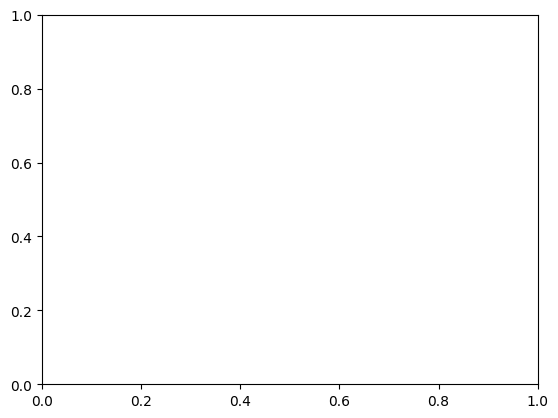

In [4]:
# sphinx_gallery_thumbnail_number = 5
# sphinx_gallery_thumbnail_number = 5

import jax.experimental
from ott.geometry import pointcloud
from ott.tools import sinkhorn_divergence

batch_size = 32

dataloader= dataset["train.clean.360"].batch(batch_size=batch_size)

@eqx.filter_jit
def partialed(x, y):
    return sinkhorn_divergence.sinkhorn_divergence(
            pointcloud.PointCloud,
            x=x,
            y=y,
            epsilon=0.05,
        )[1].divergence

@eqx.filter_jit
@eqx.filter_value_and_grad(has_aux=True)
def calculate_losses(model, x):
    y = jax.vmap(model)(x)
    # loss = jnp.mean(jax.vmap(partialed, in_axes=(0,0))(x, y))

    # return jnp.mean((x-y)**2), (y, loss)
    return jnp.mean((x-y)**2), y 


@eqx.filter_jit
def make_step(model, optimizer, opt_state, x):
    (total_loss, y), grads = (
        calculate_losses(model, x)
    )
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)

    return (
        model,
        opt_state,
        total_loss,
        grads,
        y,
    )
    
key = jax.random.key(3)

def reset_params(x):
    global key
    key, grab= jax.random.split(key)
    if hasattr(x, "weight"):
        var = 3.6/(jnp.cumprod(x.weight.shape))
        x.weight = jax.nn.initializers.normal(var)(grab, shape=x.weight.shape)
    return x
        

jax.tree_map(reset_params, model)
    
fig, ax = plt.subplots(1)
# fig.show()
step = 0


In [5]:

for epoch in range(epochs):
    # eqx.tree_serialise_leaves(f"checkpoints/{epoch}.eqx", model)
    for batch in dataloader:
        input = jnp.expand_dims(jnp.array(batch["audio"]), 1)
        model, opt_state, total_loss, grads, y = make_step(model, optimizer, opt_state, input)
        

        # Log codebook updates to TensorBoard
        writer.add_scalar('Loss/MSE', total_loss, step)
        # time.sleep(3)
        step+=1
        if (step // batch_size) % 8 == 0:
            ax.clear()
            ax.plot(batch["audio"][0])
            ax.plot(y[0][0])
            display(fig)
            clear_output(wait=True)
            
    # plt.imshow(y[0])otal_loss}")

KeyboardInterrupt: 

In [ ]:


jax.tree_util.tree_map_with_path(lambda p, x: print(f"{jax.tree_util.keystr(p)} :{jnp.mean(x)}"), grads)

SyntaxError: unterminated string literal (detected at line 1) (798860864.py, line 1)

In [25]:
eqx.tree_serialise_leaves("checkpoints/fsq.eqx", model)

In [ ]:


model = eqx.tree_deserialise_leaves("checkpoints/fsq.eqx", model)


In [44]:
data = iter(dataloader)

In [64]:
import numpy as np
import IPython 

sample = next(data)["audio"][0]
IPython.display.Audio(sample, rate=16000)


In [65]:

y = model(jnp.expand_dims(sample,0))
z = model.encoder(jnp.expand_dims(sample, 0))
codes = model.quantizer.codes_to_indexes(jnp.expand_dims(model.quantizer(z), -1))
print(codes)

IPython.display.Audio(y, rate=16000)

[[ 8  3  7  4  8  5  8  6  8  8  6  9  8  8  9  8  8  8  8  8  8  8  8  8
   9  8  9  7  8  5  6 10  5 11  5 11  6 10  7  9  8  8  8  8  9  8  9  9
   9  7  9 11  6  3  3  6  9 10 13 15 14 13 12  7  8  7  8  8  8  8  8  3
   8 10  3 10  5 10  6 11]]


In [56]:
len(codes[0])

80

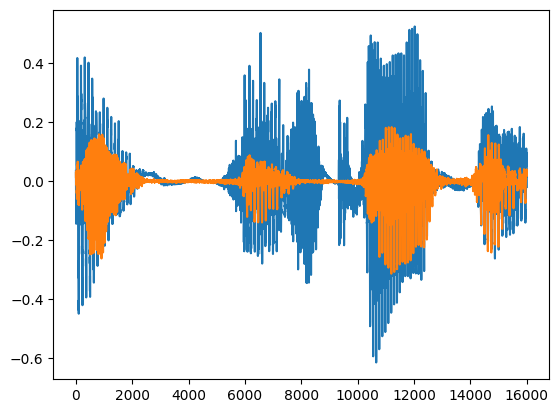

In [66]:
fig, ax = plt.subplots(1)
ax.plot(sample)
ax.plot(y[0])
fig.show()

In [4]:
# sphinx_gallery_thumbnail_number = 5

import torch
import matplotlib.pylab as pl
from geomloss import SamplesLoss  # See also ImagesLoss, VolumesLoss
import jax
import numpy as np

loss = SamplesLoss(loss="sinkhorn", p=1, blur=.05)

test = jax.random.normal(jax.random.key(1), shape=(1,100))
test2 = jax.random.normal(jax.random.key(3), shape=(1,100))


a = torch.from_numpy(np.array(test))
b = torch.from_numpy(np.array(test2))

L = loss(a, b)
print(L)


tensor(12.7662)


In [37]:
from ott.geometry import pointcloud
from ott.solvers import linear
from ott.geometry.costs import EuclideanP
from ott.tools import plot, sinkhorn_divergence

# print(sample.shape)
# print(y[0].shape)
# a= jnp.stack([sample, jnp.arange(0, sample.shape[-1])])
# b= jnp.stack([y[0], jnp.arange(0, y.shape[-1])])
# print(a.shape)
# print(b.shape)
# geom = pointcloud.PointCloud(jnp.transpose(a), jnp.transpose(b),epsilon=10,cost_fn=EuclideanP(2))
# solve_fn = jax.jit(linear.solve)
test = jax.random.normal(jax.random.key(1), shape=(1,100))
test2 = jax.random.normal(jax.random.key(1), shape=(1,100))*0.9
# ot = solve_fn(geom)
print(sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud,
        x=jnp.expand_dims(sample, 0),
        y=y,
        epsilon=0.05,
    )[1].divergence)
# print(f"OT Cost, lower bound = {ot.dual_cost:3f}, upper = {ot.primal_cost:3f}")

244.59985


In [ ]:
from ott.geometry import pointcloud
from ott.solvers import linear
from ott.geometry.costs import EuclideanP

print(sample.shape)
print(y[0].shape)
a= jnp.stack([sample, jnp.arange(0, sample.shape[-1])])
b= jnp.stack([y[0], jnp.arange(0, y.shape[-1])])
print(a.shape)
print(b.shape)
geom = pointcloud.PointCloud(jnp.transpose(a), jnp.transpose(b),epsilon=10,cost_fn=EuclideanP(2))
solve_fn = jax.jit(linear.solve)
ot = solve_fn(geom)
print(f"OT Cost, lower bound = {ot.dual_cost:3f}, upper = {ot.primal_cost:3f}")

(16000,)
(16000,)
(2, 16000)
(2, 16000)
OT Cost, lower bound = -114.000366, upper = 5.037583


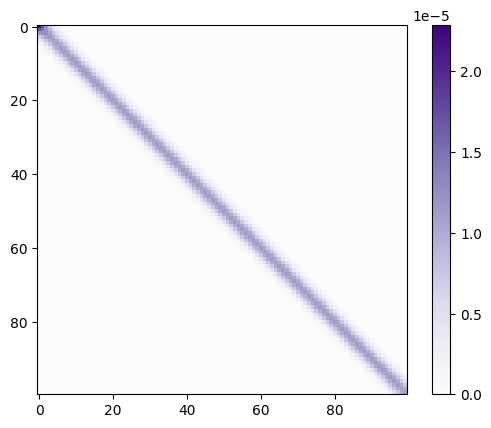

In [60]:
import matplotlib.pyplot as plt
from IPython import display

P = ot.matrix
plt.imshow(P[:100, :100], cmap="Purples")
plt.colorbar()

In [35]:
print(ot.reg_ot_cost)

0.49930465


In [ ]:
eqx.tree_serialise_leaves("checkpoints/fsq.eqx", model)